# Code to accompany publication 
This notebook gives figures and estimation procedures.

## Initialization

In [1]:
!pip install autograd

  Running setup.py bdist_wheel for autograd ... done
  Stored in directory: /home/nbuser/.cache/pip/wheels/72/6f/c2/40f130cca2c91f31d354bf72de282922479c09ce0b7853c4c5
Successfully built autograd


In [2]:
# imports
import autograd.numpy as np
from autograd import grad
import scipy.io as sio
import matplotlib
import matplotlib.pyplot as plt
from autograd.scipy.signal import convolve
from scipy.optimize import minimize
import numpy.matlib as ml

/home/nbuser/anaconda2_501/lib/python2.7/site-packages/matplotlib/font_manager.py:279: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


In [3]:
# config
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Data functions

In [4]:
def extract(trials, prop):
    # extracts given property from all trials and returns it as a list
    result = range(len(trials))
    for i in range(len(trials)):
        result[i] = trials[i].__dict__[prop]
    return result

def insert(trials, propname, propvalue):
    for i in range(len(trials)):
        trials[i].__dict__[propname] = propvalue[i]
    
def plot_trial(trial, figsize=(8,4)):
    # plots a single trial
    plt.figure(figsize=figsize)
    x = np.linspace(-5,5,len(trial.stimulus))
    plt.plot(x, trial.stimulus)
    plt.plot(x, trial.target)
    a, = plt.plot(x[trial.response],0,'bo')
    b, = plt.plot(x[trial.truepos],0,'ko')
    plt.xlabel('Position (degrees)')
    plt.ylabel('contrast')
    plt.legend((a,b),('subject response', 'edge location'))
    
def plotresults(trials):
    # subject position and actual position
    actual = np.array(extract(trials,'truepos'))
    obs = np.array(extract(trials,'response'))
    plt.figure(figsize=(15,4))
    plt.plot(actual-obs,'.')
    plt.plot((0,len(trials)),(0,0),'k')
    plt.xlabel('Trial');
    plt.ylabel('error (pixels)');
    print np.sum(np.abs(actual-obs)<10)

In [5]:
# actually read everything
# Each of the data files contains a long array of objects. Each object represents a trial, 
# and has the following properties:
# .stimulus - the contrast profile of the stimulus on that trial
# .response - the pixel that the observer clicked on
# .truepos - the pixel that the edge was actually located
#
# Other fields are not used here.

trials = dict()
trials['w'] = np.load('data/w.npy')
trials['a'] = np.load('data/a.npy')
trials['t'] = np.load('data/t.npy')
trials['h'] = np.load('data/h.npy')
trials['c'] = np.load('data/c.npy')
trials['w0'] = np.load('data/w0.npy')
trials['h0'] = np.load('data/h0.npy')
trials['c0'] = np.load('data/c0.npy')
monitor = np.load('data/monitor.npy')

### Figure 1
Stimulus, taken from observer "A" trial #500

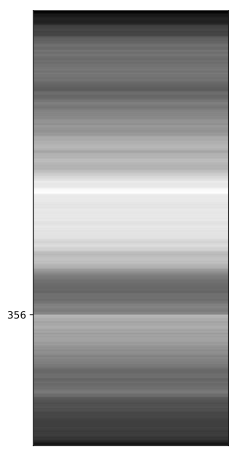

In [6]:
trialno = 500
s = trials['a'][trialno].stimulus
w = int(4.5/10.0*len(s)) # number of pixels in 4.5 degrees
s = np.transpose(ml.repmat(s, w, 1))
fig1 = plt.figure(figsize=(3.5,20))
plt.imshow(s, cmap = 'gray')
plt.yticks([trials['a'][trialno].truepos-2]) # not sure why off by 2 here?
plt.xticks([]);
fig1.savefig('figures/figure1.svg');

### Figure 2
Diagram showing the model. Using the same stimulus as above

/home/nbuser/anaconda2_501/lib/python2.7/site-packages/autograd/scipy/signal.py:41: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  A_view = A[flipped_idxs]


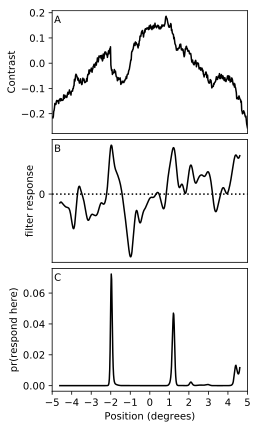

In [7]:
s = trials['a'][trialno].stimulus
fig2, ax = plt.subplots(3, sharex=True, figsize=(3.5,7))

# the stimulus
x = np.linspace(5,-5,len(s))
ax[0].plot(x,s,'k');
ax[0].set(ylabel='Contrast',xlim=[-5,5])
ax[0].tick_params(axis='x', bottom='off')
ax[0].text(0.01,0.9,'A', transform = ax[0].transAxes)

# the filter
filtx = np.array(range(-20,21))
filt = -filtx*np.exp(-(filtx**2)/(2.0*6**2))
# the filtered stimulus
f = convolve(s, filt, mode='valid')
pad = (len(s)-len(f))/2
f = np.hstack((np.zeros(pad)*np.nan, f))
pad = len(s)-len(f)
f = np.hstack((f,np.zeros(pad)*np.nan))
ax[1].plot(x,f,'k')
ax[1].plot((-5,5),(0,0),'k:')
ax[1].set(xticks=[], yticks=[0], ylabel='filter response', xlim=[-5,5])
ax[1].tick_params(axis='x', bottom='off')
ax[1].text(0.01,0.9,'B', transform = ax[1].transAxes)

# the softmax
soft = np.exp(3*f)
soft[np.isnan(soft)]=0
soft = soft/np.sum(soft)
soft[soft==0] = np.nan
ax[2].plot(x,soft,'k')
ax[2].set(xlabel='Position (degrees)', ylabel='pr(respond here)',xlim=[-5,5], xticks=range(-5,6), yticks=[0,0.02, 0.04, 0.06]);
ax[2].text(0.01,0.9,'C', transform = ax[2].transAxes)

fig2.subplots_adjust(hspace=0.05)
fig2.savefig('figures/figure2.svg')

### Figure 3: Accuracy of Clicks
No independent measure, but can look at variance as a function of edge contrast

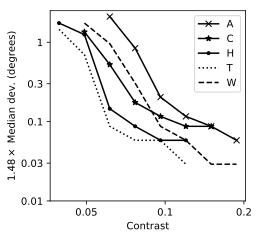

In [6]:
import scipy.stats as stats
bploterrs = {}
ucon = {}
iqr = {}
mad = {}
for subj in ['a','c','h','t','w']:
    con = extract(trials[subj],'contrast')
    err = np.array(extract(trials[subj],'response')) - extract(trials[subj],'truepos')
    ucon[subj] = np.unique(np.round(con, decimals = 5))
    bploterrs[subj] = []
    iqr[subj] = []
    mad[subj] = []
    for u in ucon[subj]:
        errs = err[np.abs(con-u)<0.0001]
        if len(errs)>10:
            bploterrs[subj].append(errs)
            iqr[subj].append(1.349*stats.iqr(errs))
            mad[subj].append(1.4826*np.median(np.abs(errs)))
            #print subj, u, iqr[subj][-1], mad[subj][-1]

fig = plt.figure(figsize=(3.5,3.5))
subj = 'a'
n = len(bploterrs[subj])
a, = plt.loglog(ucon[subj][:n],np.array(mad[subj][:n])/(510.0/10.0),'kx-')
subj = 'c'
n = len(bploterrs[subj])
b, = plt.plot(ucon[subj][:n],np.array(mad[subj][:n])/(510.0/10.0),'k*-')
subj = 'h'
n = len(bploterrs[subj])
c, = plt.plot(ucon[subj][:n],np.array(mad[subj][:n])/(510.0/10.0),'k.-')
subj = 't'
n = len(bploterrs[subj])
d, = plt.plot(ucon[subj][:n],np.array(mad[subj][:n])/(510.0/10.0),'k:')
subj = 'w'
n = len(bploterrs[subj])
e, = plt.plot(ucon[subj][:n],np.array(mad[subj][:n])/(510.0/10.0),'k--')
plt.legend((a,b,c,d,e),('A','C','H','T','W'))
plt.ylim((0.01,2.5))
plt.ylabel(r'$1.48 \times $ Median dev. (degrees)')
plt.xlabel('Contrast');
plt.xticks([])
plt.minorticks_off()
plt.xticks((0.05,0.1,0.2),('0.05','0.1','0.2'));
plt.yticks((0.01,0.03,0.1,0.3,1),('0.01','0.03','0.1','0.3','1',));
fig.savefig('figures/figure3.svg');

## Analysis functions

In [10]:
def conv(filt, trial):
    # the convolution of filter with stimulus
    return convolve(trial.stimulus, filt, mode='valid')

def softmax(z):
    # The softmax function for turning filter outputs into probabilities
    # needs to be changed to avoid extremes, as observers were told about this
    p = np.exp(z)
    return p/np.sum(p)  
    
def calc_response(filt, trial):
    # the probability of the observer response given the filter
    p = softmax(conv(filt, trial))
    return (p[trial.response - filt.shape[0]/2], np.argmax(p))

def neg_logL_trial(filt, trial):
    # the negative log likelihood of the observer response on a single trial
    return -np.log(calc_response(filt, trial)[0])

def filtplot(res, trials):
    #plot of the filter(s)
    w = res['full'].x.shape[0]/(1.0*trials[0].stimulus.shape[0])*10
    x = np.linspace(-w/2, w/2, res['full'].x.shape[0])
    a, = plt.plot(x, res['200'].x,linewidth=1)
    b, = plt.plot(x, res['full'].x,'k',linewidth=2)
    c, = plt.plot(x, res['wrong'].x,'r',linewidth=1)
    plt.legend((a,b,c),('200 trials','all trials', 'wrong trials'))
    plt.xticks(np.arange(-0.5, 0.51, 0.1));
    plt.xlabel('Position');

def plot_response(filt, trial, style = 'prob', figsize=(8,4)):
    # plots a response of the filter and observer in a single trial
    # style is either 'prob' (probability) or 'filt' (raw filter output)
    (pr, filterpos) = calc_response(filt, trial)
    plt.figure(figsize=figsize)
    x = np.linspace(-5,5,len(trial.stimulus))
    if style=='prob':
        z = softmax(conv(filt, trial))
        level = np.min(z)
    elif style=='filt':
        z = conv(filt, trial)
        level = 0.0
    # pad z
    pad = (trial.stimulus.shape[0]-z.shape[0])/2
    z = np.hstack((np.nan*np.zeros(pad),z))
    z = np.hstack((z, np.nan*np.zeros(trial.stimulus.shape[0]-z.shape[0])))
    # plot
    plt.plot(x, z)
    a, = plt.plot(x[trial.response],level,'bo')
    b, = plt.plot(x[trial.truepos], level, 'ko')
    c, = plt.plot(x[filterpos+pad], level, 'rs')
    plt.xlabel('Position (degrees)')
    if style=='prob':
        plt.ylabel('probability')
    elif style=='filt':
        plt.ylabel('filter response')
    plt.legend((a,b,c),('subject response', 'edge location','filter location'))

def plotoutput(res, trials):
    # plot of the observer and filter locations
    filtpos = np.zeros(len(trials))
    pos = extract(trials, 'response')
    for i in range(len(trials)): 
        (pr, filtpos[i]) = calc_response(res['full'].x, trials[i])
    #plt.figure(figsize=(20,4))
    filtpos = filtpos + res['full'].x.shape[0]/2
    plt.plot(filtpos-pos,'.')
    plt.plot((0,len(trials)),(0,0),'k')
    plt.xlabel('Trial')
    plt.ylabel('Model-actual position (pixels)')
    print np.sum(np.abs(filtpos-pos)<10)


### Define & fit convolutional filter

In [11]:
# smoothness penalty on the filter
def l2penalty(filt):
    len = filt.shape[0]
    return np.sum(np.diff(np.hstack((np.zeros(2),filt,np.zeros(2))), n=2)**2)/(0.1+np.sum(filt**2))

# gradient functions
grad_penalty = grad(l2penalty)
grad_neg_logL_trial = grad(neg_logL_trial)

# generic functions for minimize
def nlogL(filt, trials):
    return reduce((lambda x,t: x+neg_logL_trial(filt, t)), trials, 0) + pwt*l2penalty(filt)

def nlogL_grad(filt, trials):
    return reduce((lambda x,t: x+grad_neg_logL_trial(filt, t)), trials, 0) + pwt*grad_penalty(filt)

try:
    res = np.load('results.npy').flat[0]
except:
    print 'New results'
    res = dict()
    
class Dummy():
    def __init__(self, value):
        self.x = value

### All observers
First, fit without any penalty weight at all, then penalty, then wrong.

In [46]:
# fit to all
for subj in ('a','c','h','t','w','w0','h0','c0'):
    # setup res[subj]
    if subj not in res:
        res[subj] = dict()
    RES = res[subj]
    T = trials[subj]
    
    # unpenalized fit
    if 'unpenalized' not in RES:
        RES['unpenalized'] = Dummy(np.zeros(80) if subj[1]=='0' else np.zeros(48))
    pwt = 0
    f = lambda x: nlogL(x, T)
    df = lambda x: nlogL_grad(x, T)
    print subj+': fit unpenalized'
    RES['unpenalized'] = minimize(f, RES['unpenalized'].x, jac = df, method='BFGS', options={'disp': True})
    np.save('results', res)
    
    # penalized fit
    if 'penalized' not in RES:
        RES['penalized'] = RES['unpenalized']
    pwt = 25
    f = lambda x: nlogL(x, T)
    df = lambda x: nlogL_grad(x, T)
    print subj+': fit penalized'
    RES['penalized'] = minimize(f, RES['penalized'].x, jac = df, method='BFGS', options={'disp': True})
    np.save('results', res)
    
    # fit to wrong trials
    if 'wrong' not in RES:
        RES['wrong'] = RES['penalized']
    pwt = 25
    wrong = filter(lambda t: abs(t.truepos-t.response)>10, T)
    f = lambda x: nlogL(x, wrong)
    df = lambda x: nlogL_grad(x, wrong)
    print subj+': fit wrong'
    RES['wrong'] = minimize(f, RES['wrong'].x, jac = df, method='BFGS', options={'disp': True})
    np.save('results', res)
    res

a: fit unpenalized
Optimization terminated successfully.
         Current function value: 8298.086188
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
a: fit penalized
Optimization terminated successfully.
         Current function value: 8313.475837
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
a: fit wrong
Optimization terminated successfully.
         Current function value: 3070.044409
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
c: fit unpenalized
Optimization terminated successfully.
         Current function value: 8431.851300
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
c: fit penalized
Optimization terminated successfully.
         Current function value: 8446.332994
         Iterations: 0
         Function evaluations: 1
         Gradient evaluations: 1
c: fit wrong
Optimization terminated successfully.
    

### Smoothing
Subjects with & without smoothing

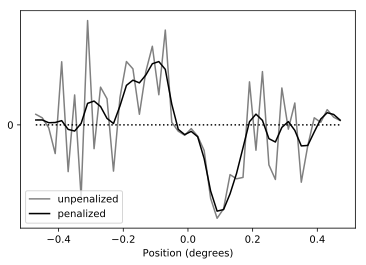

In [16]:
subj = 'c'
w = len(res[subj]['unpenalized'].x)/2.0*10.0/510.0
xf = np.linspace(-w,w,len(res['a']['penalized'].x))
fig = plt.figure()
a, = plt.plot(xf,res[subj]['unpenalized'].x, color=(0.5,0.5,0.5))
b, = plt.plot(xf,res[subj]['penalized'].x,'k')
plt.plot([xf[0],xf[-1]],(0,0),'k:')
plt.yticks([0])
plt.xlabel('Position (degrees)')
plt.legend((a,b), ('unpenalized','penalized'), loc='lower left')
fig.savefig('figures/smoothing.svg')

### Plotter routine

In [146]:
def plottemplates(res, obs, label, colours = ['k', 'b']):
    # res is the results
    # obs is the observer codes
    # label is ('wrong', 'penalized') usually
    # colours is the colours for the labels
    
    # work out the x axis from 'a' who is always there
    w = len(res['a'][label[0]].x+2)/2.0*10.0/510.0
    xf = np.linspace(-w,w,len(res['a'][label[0]].x)+2)

    # the subplot array
    figg, ax = plt.subplots(int(round(len(obs)/2.0)), 2, figsize=(7.5,10.0))

    tx = 0.05
    ty = 0.9

    def padt(r):
        return np.hstack((0,r.x,0))

    label = zip(label, colours)
    row = 0
    col = 0
    for observer in obs:
        for L in label:
            ax[row,col].plot(xf, padt(res[observer][L[0]]), color=L[1])
        ax[row,col].text(tx,ty,observer.upper(), transform = ax[row,col].transAxes)
        #ax[row,col].set(ylim=(-15,15), xlabel='Position (degrees)')
        col = col+1
        if col>1:
            col = 0
            row = row+1

    return figg, ax


### Figure 4
All the templates, right and wrong

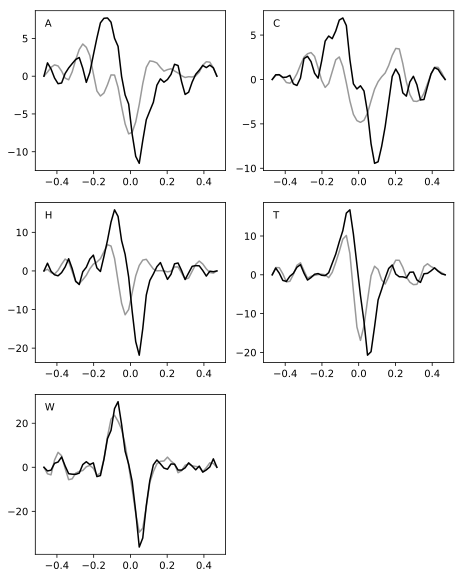

In [147]:
fig, ax = plottemplates(res, ('a','c','h','t','w'), ('wrong','penalized'), colours=[(0.6,0.6,0.6),'k'])
ax[2,1].axis('off')
fig.savefig('figures/figure4.svg')

In [ ]:
# use this to measure peak-to-trough width.
(np.argmin(res['a']['penalized'].x)-np.argmax(res['a']['penalized'].x))*10/510.0

### Figure 5
Frequency spectra

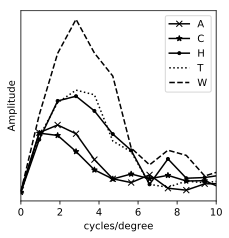

In [12]:
spectra = dict()
fft = np.fft.fft
for obs in res:
    spectra[obs] = abs(fft(res[obs]['penalized'].x))
freq = np.fft.fftfreq(len(res['a']['penalized'].x))
fr = range(0,24)
cycles_per_48 = np.array(freq[fr])*48
cycles_per_degree = cycles_per_48*(48/510.0)*10
frx=cycles_per_degree
fig = plt.figure(figsize = (3.5,3.5))
a, = plt.plot(frx, spectra['a'][fr],'kx-')
c, = plt.plot(frx, spectra['c'][fr],'k*-')
h, = plt.plot(frx, spectra['h'][fr],'k.-')
t, = plt.plot(frx, spectra['t'][fr],'k:')
w, = plt.plot(frx, spectra['w'][fr],'k--')
plt.xlim([0,10])
plt.yticks([])
plt.xlabel('cycles/degree')
plt.ylabel('Amplitude')
plt.legend((a,c,h,t,w),('A','C','H','T','W'))
fig.savefig('figures/figure5.svg')

### Figure 7: White noise filter

In [2]:
# use this when just want to plot figure 6
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.signal import convolve
from scipy.optimize import minimize
import numpy.matlib as ml
res = np.load('results.npy').flat[0]

c [-3.07463932  1.93372863  0.06125386]
h [-4.03736803  1.92068565  0.03567936]
w [-7.46826524  2.9194604   0.0386059 ]


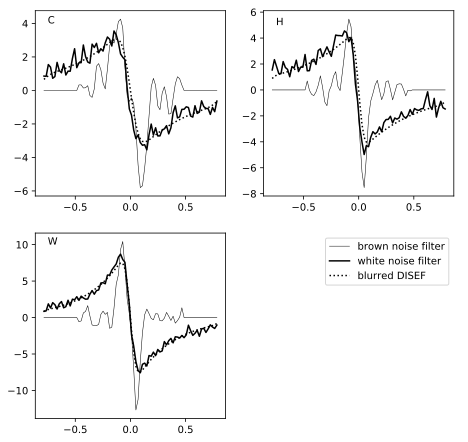

In [8]:
def bdisef(h,s,b,xin):
    # h(eight), s(cale for disef), b(lur), x
    # work out x dimension for the DISEF filter
    xstep = np.mean(np.diff(xin))
    extra = min(1, int(np.ceil(6*np.abs(b)/xstep)))
    pad = np.linspace(xstep,extra*xstep, extra)
    x = np.hstack((xin[0]-pad, xin, xin[-1]+pad))
    # work out gaussian*ISEF
    disef = np.sign(x)*np.exp(-np.abs(s*x))
    gauss = np.exp(-(x-xstep/2)**2/(2*b**2))
    disef = convolve(disef, gauss, mode='full')
    disef = disef/np.max(disef)*h
    # strip out ends of the DISEF to get back to same size as xin
    p = (len(disef)-len(xin))/2
    return disef[p+1:-p]

def fitw(params, f, x):
    # f is the function to fit over the domain x
    h = params[0]; s=params[1]; b=params[2]
    d = bdisef(h, s, b, x)
    return np.sum((d-f)**2)

def plotwhite(axis, subj):
    f0 = res[subj+'0']['penalized'].x
    w0 = len(f0)/2.0*10.0/510.0 # half-width of the stimulus
    x0 = np.linspace(-w0,w0,len(f0))
    f = res[subj]['penalized'].x
    w = len(f)/2.0*10.0/510.0
    x = np.linspace(-w,w,48)
    scale = np.max(f0)/np.max(f)
    a, = axis.plot(x0,1.2*scale*np.hstack((np.zeros(16),res[subj]['penalized'].x,np.zeros(16))),'k',lw=0.5)

    result = minimize(fitw, [-6,3,0.05], args=(f0,x0))
    x = result.x
    print subj, x
    b, = axis.plot(x0,f0,'k')
    c, = axis.plot(x0,bdisef(x[0], x[1], x[2], x0),'k:')
    return a,b,c
    
fig, ax = plt.subplots(2, 2, figsize=(7.5,7.5))
plotwhite(ax[0,0], 'c')
plotwhite(ax[0,1], 'h')
plots = plotwhite(ax[1,0], 'w')

ax[0,0].text(-0.75, 4, 'C')
ax[0,1].text(-0.75, 5, 'H')
ax[1,0].text(-0.75, 10, 'W')
ax[1,1].legend(plots,('brown noise filter','white noise filter','blurred DISEF'))
ax[1,1].axis('off')

fig.savefig('figures/figure7.svg')

In [11]:
np.mean(np.array([0.06637071, 0.01340057, 0.03645999, 0.03946926, 0.05113813]))

0.041367732000000004

In [151]:
motor = np.array([mad['c0'][-1], mad['h0'][-1], mad['w0'][-1]])/(510.0/10.0)
print motor

[0.08721176 0.05814118 0.05814118]


## Figure 6
accuracy in white noise

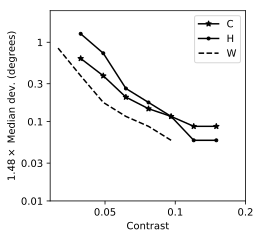

In [14]:
bploterrs = {}
ucon = {}
iqr = {}
#mad = {}
for subj in ['c0','h0','w0']:
    con = extract(trials[subj],'contrast')
    err = np.array(extract(trials[subj],'response')) - extract(trials[subj],'truepos')
    ucon[subj] = np.unique(np.round(con, decimals = 5))
    bploterrs[subj] = []
    iqr[subj] = []
    mad[subj] = []
    for u in ucon[subj]:
        errs = err[np.abs(con-u)<0.0001]
        if len(errs)>10:
            bploterrs[subj].append(errs)
            iqr[subj].append(1.349*stats.iqr(errs))
            mad[subj].append(1.4826*np.median(np.abs(errs)))
            #print subj, u, iqr[subj][-1], mad[subj][-1]

fig = plt.figure(figsize=(3.5,3.5))
subj = 'c0'
n = len(bploterrs[subj])
a, = plt.loglog(ucon[subj][:n],np.array(mad[subj][:n])/(510.0/10.0),'k*-')
subj = 'h0'
n = len(bploterrs[subj])
b, = plt.plot(ucon[subj][:n],np.array(mad[subj][:n])/(510.0/10.0),'k.-')
subj = 'w0'
n = len(bploterrs[subj])
c, = plt.plot(ucon[subj][:n],np.array(mad[subj][:n])/(510.0/10.0),'k--')

plt.legend((a,b,c),('C','H','W'))
plt.ylim((0.01,2.5))
plt.ylabel(r'$1.48 \times $ Median dev. (degrees)')
plt.xlabel('Contrast');
plt.xticks([])
plt.minorticks_off()
plt.xticks((0.05,0.1,0.2),('0.05','0.1','0.2'));
plt.yticks((0.01,0.03,0.1,0.3,1),('0.01','0.03','0.1','0.3','1',));
fig.savefig('figures/figure6.svg');

### Figure 8: Shapley & Tolhurst 1973
A figure to compare their subthreshold summation data with mine

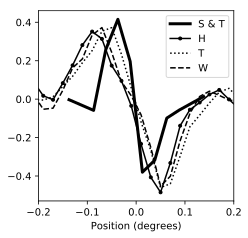

In [23]:
Shap_Tol_data = np.array([[-0.13744026019028763, 0.003013507309496566],
[-0.08714536496472317, 0.05848089821233504],
[-0.0621451450905616, -0.2579704383587186],
[-0.03739083247875563, -0.41524695386336496],
[-0.012252355731767473, -0.19629872631295664],
[0.01284284978021391, 0.38027253842081077],
[0.03810269706441613, 0.3180829787496018],
[0.06279368591767562, 0.098791395708408],
[0.08807464112139343, 0.05727352521604823],
[0.13824077803791326, -0.013356387872093145]])

figst = plt.figure(figsize=(3.5,3.5))
a, = plt.plot(Shap_Tol_data[:,0], -Shap_Tol_data[:,1],'k',linewidth=3)
#b, = plt.plot(xf,res['a']['penalized'].x/20,'k+-')
#b, = plt.plot(xf,res['c']['penalized'].x/20,'k*-')
b, = plt.plot(xf,res['h']['penalized'].x/45,'k.-')
c, = plt.plot(xf,res['t']['penalized'].x/45,'k:')
d, = plt.plot(xf,res['w']['penalized'].x/80,'k--')
plt.legend((a,b,c,d),('S & T','H','T','W'), loc='upper right')
plt.xlabel('Position (degrees)')
plt.xlim([-0.2,0.2])
figst.savefig('figures/figure8.svg')

In [149]:
def p2t(filt): # peak to trough distance
    return np.abs(np.argmax(filt)-np.argmin(filt))/(510.0/10.0)

sigma_obs = np.array([p2t(res['a']['penalized'].x), 
                      p2t(res['c']['penalized'].x), 
                      p2t(res['h']['penalized'].x), 
                      p2t(res['t']['penalized'].x), 
                      p2t(res['w']['penalized'].x)])/2
motor = np.array([mad['a'][-1], mad['c'][-1], mad['h'][-1], mad['t'][-1], mad['w'][-1]])/(510.0/10.0)
np.sqrt(sigma_obs**2-motor**2)

array([0.06637071, 0.01340057, 0.03645999, 0.03946926, 0.05113813])

In [144]:
print sigma_obs, motor

[0.08823529 0.08823529 0.06862745 0.04901961 0.05882353] [0.05814118 0.08721176 0.05814118 0.02907059 0.02907059]
